In [7]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import os
import scipy.constants as const

#import ParticlePlottingFunctions
import ParticlePlottingFunctions as ppf
%load_ext autoreload 
%autoreload 2

# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# file1 = "500UCN_Fill_minus1_moreTimes.root"

# file1 = "1000UCN_fill_minus1_snapGeo1.root"
file1 = "4000UCN_fill_m1.root"


#get our two different data folders already for ease
Nend = up.open(file1+":neutronend")
Nsnapshot = up.open(file1+":neutronsnapshot")

# Nsnapshot.keys()

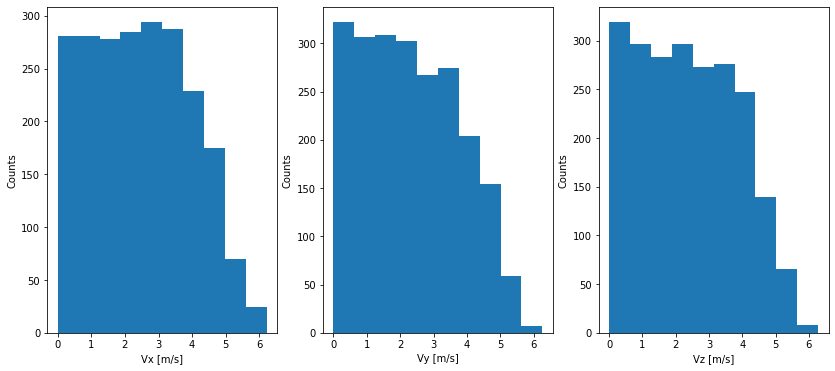

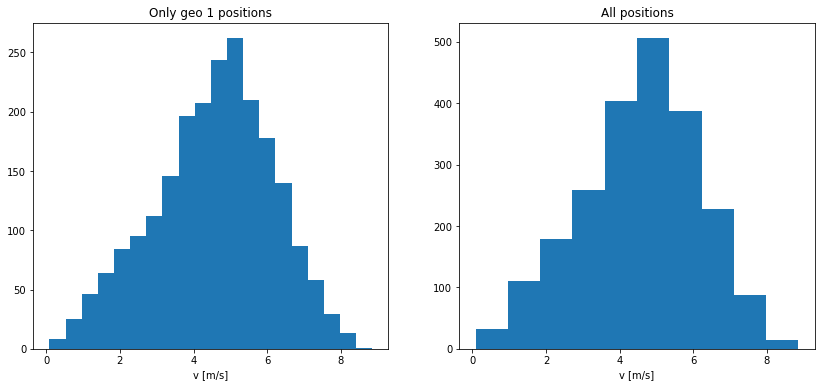

In [22]:
#all UCNs
particleSS_all = Nsnapshot.arrays(["vxend", "vyend", "vzend"])

#only ones in the #1 default geometry -> basically not in the He or the cell
particleSS_geo1 = Nsnapshot.arrays(["vxend", "vyend", "vzend"],  "solidend == 1")

Vx = np.abs(particleSS_geo1['vxend'])
Vy = np.abs(particleSS_geo1['vyend'])
Vz = np.abs(particleSS_geo1['vzend'])

V_mag_1 = np.sqrt(particleSS_geo1['vxend']**2 + particleSS_geo1['vyend']**2 + particleSS_geo1['vyend']**2)
V_mag_all = np.sqrt(particleSS_all['vxend']**2 + particleSS_all['vyend']**2 + particleSS_all['vyend']**2)

fig, axs = plt.subplots(1, 3, figsize=(14,6))

axs[0].hist(Vx)
axs[0].set_xlabel('Vx [m/s]')
axs[0].set_ylabel('Counts')

axs[1].hist(Vy)
axs[1].set_xlabel('Vy [m/s]')
axs[1].set_ylabel('Counts')

axs[2].hist(Vz)
axs[2].set_xlabel('Vz [m/s]')
axs[2].set_ylabel('Counts')

plt.show()

# total magnitude of velocity
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].hist(V_mag_1, bins=20)
axs[0].set_title("Only geo 1 positions")
axs[0].set_xlabel("v [m/s]")
axs[1].hist(V_mag_all)
axs[1].set_title("All positions")
axs[1].set_xlabel("v [m/s]")

plt.show()

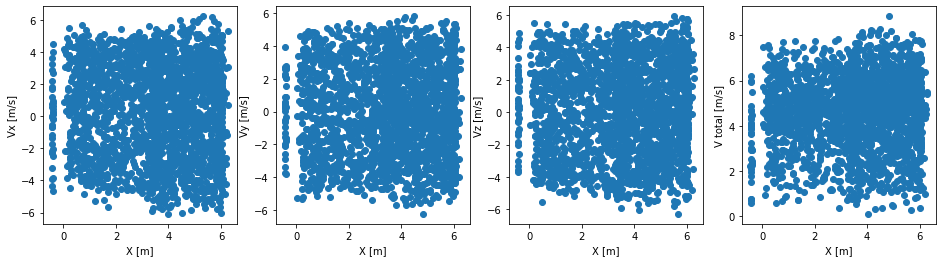

In [19]:
## Look at velocity vs x position

particleSS_geo1 = Nsnapshot.arrays(["tend", "xend", 
            "yend", "zend", 'solidend', 'particle', "vxend", "vyend", "vzend", ],  "solidend == 1")

fig, axs = plt.subplots(1, 4, figsize=(16,4))

axs[0].plot(particleSS_geo1['xend'], particleSS_geo1['vxend'], ls="", marker="o")
axs[0].set_ylabel('Vx [m/s]')
axs[0].set_xlabel('X [m]')

axs[1].plot(particleSS_geo1['xend'], particleSS_geo1['vyend'], ls="", marker="o")
axs[1].set_ylabel('Vy [m/s]')
axs[1].set_xlabel('X [m]')

axs[2].plot(particleSS_geo1['xend'], particleSS_geo1['vzend'], ls="", marker="o")
axs[2].set_ylabel('Vz [m/s]')
axs[2].set_xlabel('X [m]')

V_mag_1 = np.sqrt(particleSS_geo1['vxend']**2 + particleSS_geo1['vyend']**2 + particleSS_geo1['vyend']**2)

axs[3].plot(particleSS_geo1['xend'], V_mag_1, ls="", marker="o")
axs[3].set_ylabel('V total [m/s]')
axs[3].set_xlabel('X [m]')

plt.show()

## Looking at energy distributions

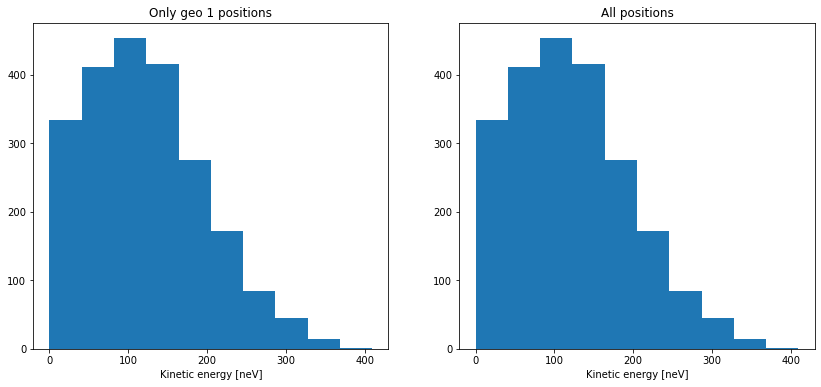

In [20]:
m_c = const.physical_constants["neutron mass energy equivalent in MeV"][0] * 1e6 #in eV
c = const.c #m/s

#converts non rel particle speed to kinetic energy
#only an approximation
E_K = lambda v, mc2: 1/2 *mc2*(v/c)**2 

#first looking at the resulting kinetic energy from the velocity that pentrack saves
#I think this is wrong and I should stick with what the code does

fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].hist(E_K(V_mag_1, m_c)*1e9)
axs[0].set_title("Only geo 1 positions")
axs[0].set_xlabel("Kinetic energy [neV]")

axs[1].hist(E_K(V_mag_all, m_c)*1e9)
axs[1].set_title("All positions")
axs[1].set_xlabel("Kinetic energy [neV]")

plt.show()

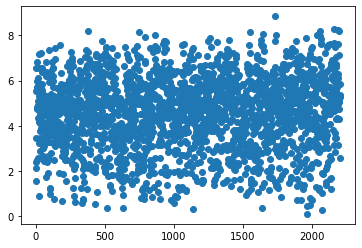

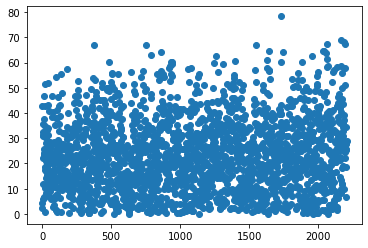

In [21]:
x = np.linspace(0, len(V_mag_all), len(V_mag_all))

plt.scatter(x, V_mag_all)
plt.show()

plt.scatter(x, V_mag_all**2)
plt.show()

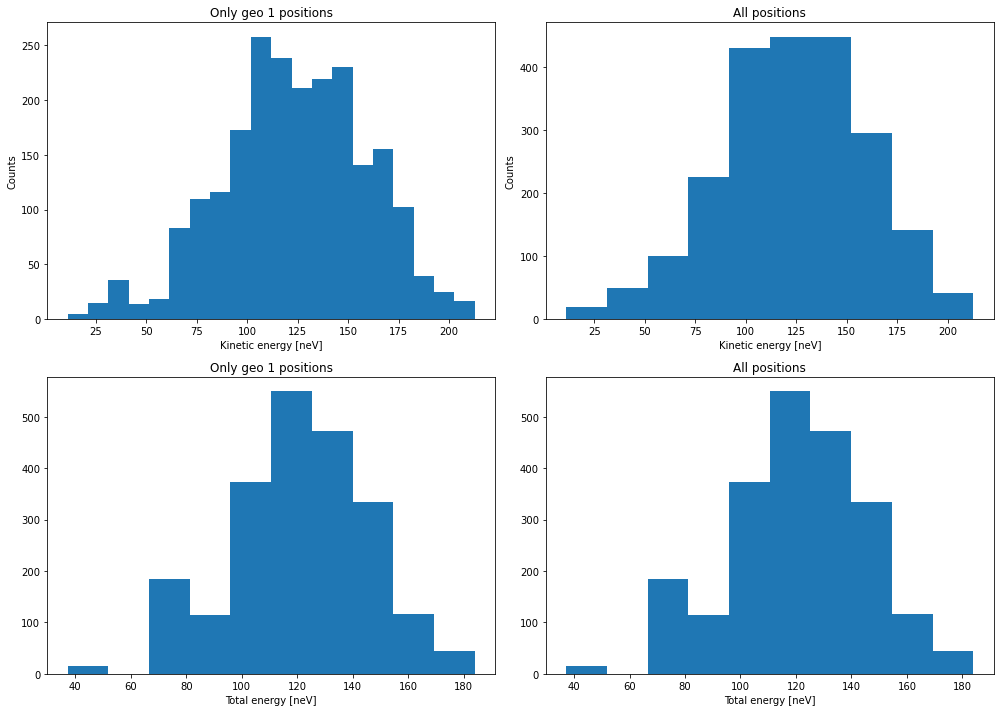

In [24]:
"""
Hend: final total energy of particle [eV]
Eend: final kinetic energy of the particle [eV]

Here we look at the actually energy that PENTrack saves, cause this is really much easier.
However these look quite different which is weird, how is PENTrack actually calculating 
the energy?
"""

#all UCNs
particleSS_all_E = Nsnapshot.arrays(["Eend", "Hend"])

#only ones in the #1 default geometry -> basically not in the He or the cell
particleSS_geo1_E = Nsnapshot.arrays(["Eend", "Hend"],  "solidend == 1")

fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs = axs.flatten()

axs[0].hist(particleSS_geo1_E["Eend"]*1e9, bins=20)
axs[0].set_xlabel('Kinetic energy [neV]')
axs[0].set_ylabel('Counts')
axs[0].set_title("Only geo 1 positions")

axs[1].hist(particleSS_all_E["Eend"]*1e9)
axs[1].set_xlabel('Kinetic energy [neV]')
axs[1].set_ylabel('Counts')
axs[1].set_title("All positions")

# total magnitude of velocity
axs[2].hist(particleSS_geo1_E["Hend"]*1e9)
axs[2].set_title("Only geo 1 positions")
axs[2].set_xlabel("Total energy [neV]")

axs[3].hist(particleSS_all_E["Hend"]*1e9)
axs[3].set_title("All positions")
axs[3].set_xlabel("Total energy [neV]")

plt.tight_layout()

plt.show()

# Trying to get Neutrons only in guides

In [160]:
def aveV(neutronSS, dx):
    X_intervals = np.arange(np.min(neutronSS['xend']), np.max(neutronSS['xend']), dx)
    averages = []

    for i, interval in enumerate(X_intervals):
        if i != len(X_intervals) - 1:
            cutArr = np.where((interval <= neutronSS['xend']) & (neutronSS['xend'] <= X_intervals[i+1]))
        else:
            cutArr = np.where((interval <= neutronSS['xend']))
            
        numUCNs = len(cutArr[0])      

        V_mag_1 = np.sqrt(neutronSS['vxend'][cutArr]**2 + 
                          neutronSS['vyend'][cutArr]**2 + neutronSS['vyend'][cutArr]**2)
        
        averageV =  np.average(V_mag_1)
        stdV = np.std(V_mag_1)
        averages.append([interval, averageV, stdV])
    
    return np.transpose(averages)
        

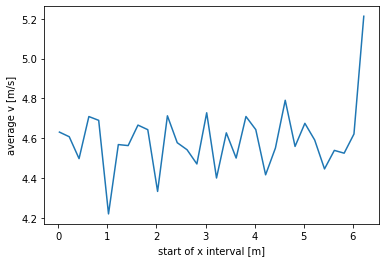

In [155]:
endSpots = Nsnapshot.arrays(["tend", "xend", "yend", "zend", "vxend", "vyend", "vzend", 'solidend', 'particle'], 
                            "(solidend==1) & (xend > 0)", library="np")

dx = 0.2
averageV_data = aveV(endSpots, dx)

plt.plot(averageV_data[0], averageV_data[1])
plt.xlabel("start of x interval [m]")
plt.ylabel("average v [m/s]")
plt.show()

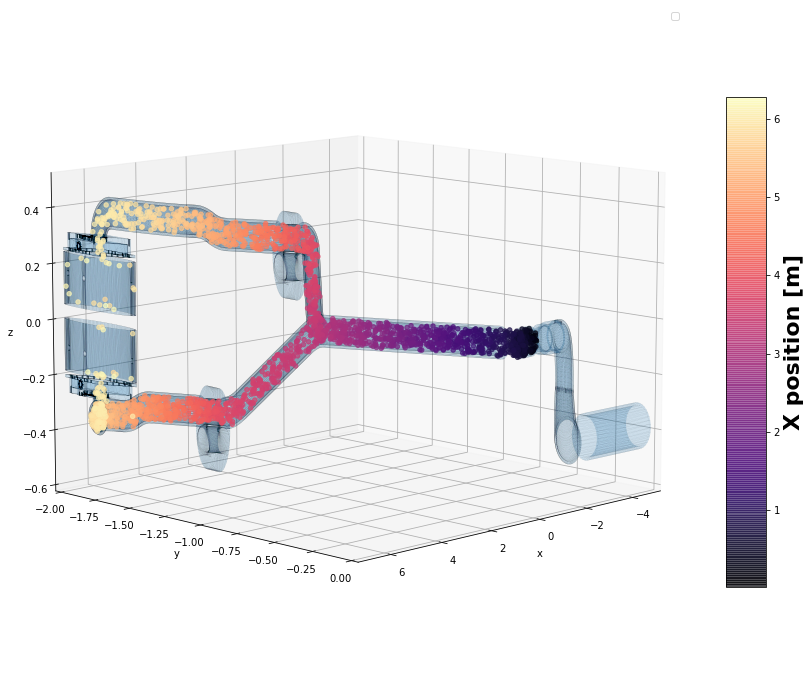

In [163]:
%matplotlib inline 
#lets you move the graph around within jupyter lab
# %matplotlib widget

#look at just one particle at different times
t = 100 #(tend%10==0) &
p = 102 #5 is good
# endSpots = Nsnapshot.arrays(["tend", "xend", "yend", "zend", 'solidend'], "(particle=={}) & (solidend==1)".format(p), library="np")

#all geo=1 aka no geometry parts, xend > 0 gets rid of weird neutrons near I think the SCM
endSpots = Nsnapshot.arrays(["tend", "xend", "yend", "zend", 'solidend', 'particle'], 
                            "(solidend==1) & (xend > 0)", library="np")

x = endSpots['xend'].astype(float)
y = endSpots['yend'].astype(float)
z = endSpots['zend'].astype(float)
times = endSpots['tend'].astype(float)
geo_tag = endSpots['solidend'].astype(float)
   
figVals = ppf.plot3D_varColor(x, y, z, x, times, label="All", startPlot=True, ls="", endPlot=False, size=(15,15))
fig, axis, p = figVals

axis.view_init(elev=10., azim=45)
# axis.view_init(elev=0., azim=90)

#loads all the file I have in this folder as STLs
STLpath = 'STLsToGraph'
stl_array = os.listdir(STLpath)

for STLfile in stl_array:
    ppf.graphSTL(STLpath+'/'+STLfile, axis)
    
#removes repeated legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axis.legend(by_label.values(), by_label.keys())

cb = fig.colorbar(p, ax=axis, shrink=0.6, aspect=20*0.6)
cb.set_label(label="X position [m]", size=22, weight='bold')
# cb.ax.tick_params(labelsize=20)
# plt.tight_layout()
plt.show()

In [16]:
#looking at the polarization
# print(Nend.keys())
neutron_pol_snap_geo1 = Nsnapshot.arrays(["polend"],  "solidend == 1")
neutron_pol_end = Nend.arrays(["polend"])

#do you want to look at the final distribution or for our snapshots?
neutron_pol = neutron_pol_end

pol_up = neutron_pol[np.where(neutron_pol["polend"] == 1)]
pol_down = neutron_pol[np.where(neutron_pol["polend"] == -1)]

totalNum = len(pol_up)+len(pol_down)

percent_down = len(pol_down)/totalNum * 100

# print(len(pol_up), len(pol_down))
print("Final polarization: {:.3}% down.".format(percent_down))

# plt.hist(neutron_pol["polend"])

Final polarization: 99.4% down.
